In [1]:
%matplotlib inline
import rebound
import os
import numpy as np
import datetime
import corner
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import matplotlib.pyplot as plt

In [2]:
def radec2xyz(ra, dec):
    x = np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = np.sin(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dra(ra, dec):
    x = -np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    y = np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def radec2xyz_ddra(ra, dec):
    x = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def radec2xyz_ddec(ra, dec):
    x = -np.pi/180.*np.sin(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.sin(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = np.pi/180.*np.cos(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dddec(ra, dec):
    x = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = -np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dra_ddec(ra, dec):
    x = np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def mod360(a):
    while a>360.:
        a-=360.
    while a<0.:
        a+=360.
    return a

In [3]:
# Meteor properties:
time = "2013-02-15 03:20:21.1" # Time [UTC]
v = 19.03                      # velocity relative to Earth [km/s]
v_err = 0.013                  # ^error
ra = 328.12                    # radiant right ascension [degree]
ra_err = 0.1                   # ^error
dec = 7.41                     # radiant declination [degree]
dec_err = 0.05                 # ^error
height = 95.*6.6845871e-09     # height [AU]
lat = 54.4540                  # latitude [degree]
lon = 64.4739                  # longitude [degree]

In [4]:
# Physical constants
re = 4.2587571e-05             # Earth radius [AU]
day = 0.017202791              # Earth day [year/(2*pi)]
inc = 23.4392911111111         # Inclination of ecliptic [degree]

vconv = 0.033572943            # 1km/s in 2*pi*AU/year
v *= vconv
v_err *= vconv

In [5]:
event = Time(time, format="iso", scale="utc")
aa_frame = AltAz(location=EarthLocation(lat=lat,lon=lon), obstime=event)

# Cache Horizon data
if not os.path.isfile("ss.bin"):
    sim = rebound.Simulation()
    te_tcb = datetime.datetime.strptime(event.tcb.iso,"%Y-%m-%d %H:%M:%S.%f")
    for p in ["Sun","Mercury","Venus","399", "301", "Mars", "Jupiter", "Saturn"]:
        sim.add(p, date=te_tcb, plane="frame")
    sim.save("ss.bin")
else:
    sim = rebound.Simulation.from_file("ss.bin")

In [6]:
# Create new meteor particle
p = sim.particles[3].copy()
p.m = 0.

# Add velocity of meteor relative to Earth's atmosphere 
p.vxyz = np.array(p.vxyz) - v*radec2xyz(ra,dec)

# Add velocity of Earth's atmosphere relative to Earth
east = SkyCoord('90deg 0deg',frame=aa_frame).transform_to("icrs")
p.vxyz = np.array(p.vxyz) + 2.*np.pi*np.cos(lat*np.pi/180.)*(re+height)/day *radec2xyz(east.ra.value, east.dec.value)

# Add position relative to Earth
up = SkyCoord('0deg 90deg',frame=aa_frame).transform_to("icrs")
p.xyz = np.array(p.xyz) + (re + height) *radec2xyz(up.ra.value, up.dec.value)

sim.add(p)

In [7]:
# Add variations
var_dv = sim.add_variation(testparticle=8)
var_dv.particles[0].vxyz = -radec2xyz(ra,dec)

var_ddv = sim.add_variation(testparticle=8, order=2, first_order=var_dv)

var_dra = sim.add_variation(testparticle=8)
var_dra.particles[0].vxyz = -v*radec2xyz_dra(ra,dec)

var_ddra = sim.add_variation(testparticle=8, order=2, first_order=var_dra)
var_ddra.particles[0].vxyz = -v*radec2xyz_ddra(ra,dec)

var_ddec = sim.add_variation(testparticle=8)
var_ddec.particles[0].vxyz = -v*radec2xyz_ddec(ra,dec)

var_dddec = sim.add_variation(testparticle=8, order=2, first_order=var_ddec)
var_dddec.particles[0].vxyz = -v*radec2xyz_dddec(ra,dec)

var_dra_ddec = sim.add_variation(testparticle=8, order=2, first_order=var_dra, first_order_2=var_ddec)
var_dra_ddec.particles[0].vxyz = -v*radec2xyz_dra_ddec(ra,dec)

var_dv_dra = sim.add_variation(testparticle=8, order=2, first_order=var_dra, first_order_2=var_dv)
var_dv_dra.particles[0].vxyz = -radec2xyz_ddra(ra,dec)

var_dv_ddec = sim.add_variation(testparticle=8, order=2, first_order=var_ddec, first_order_2=var_dv)
var_dv_ddec.particles[0].vxyz = -radec2xyz_ddec(ra,dec)

In [8]:
sim.dt = 1e-6
sim.ri_ias15.min_dt = sim.dt
sim.integrate(-60.*day)

# Rotate to ecliptic frame to calculate orbital parameters
cos = np.cos(inc/180.*np.pi)
sin = np.sin(inc/180.*np.pi)
for p in sim.particles:
    p.y, p.z = cos*p.y + sin*p.z, -sin*p.y + cos*p.z
    p.vy, p.vz = cos*p.vy + sin*p.vz, -sin*p.vy + cos*p.vz

In [49]:
def get_shadow_particle(dv, dra, ddec):
    p = sim.particles[8].copy()
    p += dv*            var_dv.particles[0]
    p += dra*           var_dra.particles[0] 
    p += ddec*          var_ddec.particles[0] 
    p += 0.5*dv*dv*     var_ddv.particles[0]       
    p += 0.5*dra*dra*   var_ddra.particles[0]       
    p += 0.5*ddec*ddec* var_dddec.particles[0]
    p += dra*ddec*      var_dra_ddec.particles[0]
    p += dv*dra*        var_dv_dra.particles[0]
    p += dv*ddec*       var_dv_ddec.particles[0]
    return p

simn = rebound.Simulation()
simn.t = -60.*day
for i in range(8):
    simn.add(sim.particles[i])
simn.N_active = simn.N

N= 1000
for i in range(N):
    dv   = v_err   * np.random.normal()
    dra  = ra_err  * np.random.normal()
    ddec = dec_err * np.random.normal()
    p = get_shadow_particle(dv, dra, ddec)
    simn.add(p)

samples = np.zeros((N,3))
for i in range(N):
    samples[i] = simn.particles[simn.N_active+i].xyz
    

In [50]:
sim.integrate(-130.*365.*day)
simn.integrate(-130.*365.*day)

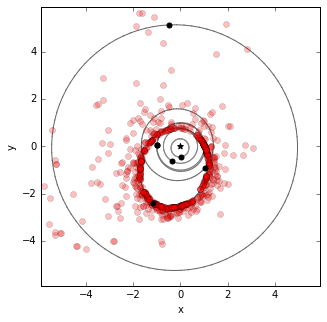

In [54]:
f = rebound.OrbitPlot(sim,lim=5.9)
samples = np.zeros((N,3))
for i in range(N):
    samples[i] = simn.particles[simn.N_active+i].xyz
    
f.axes[0].plot(samples[:,0],samples[:,1],"ro",alpha=0.25)